In [3]:
# Import libraries and initialize global variables
from  new_server_folder import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
Start_date = utils.date_range()[0]
End_date = utils.date_range()[1]
import datetime 
  
def convert2hours(n): 
    return str(datetime.timedelta(seconds = n)) 

In [4]:
# Pick start date
Start_date

DatePicker(value=datetime.date(2020, 9, 22), description='Start Date')

In [5]:
# Pick end date
End_date

DatePicker(value=datetime.datetime(2021, 5, 2, 11, 38, 35, 49291), description='End Date')

In [6]:
utils.server_db_pword

'maxhom168'

In [7]:
%%time
# database response stored in pandas dataframe
df = utils.db_connect(pem_file='newcentos.pem',
                      start_date=Start_date.value.strftime("%Y-%m-%d"),
                      end_date=End_date.value.strftime("%Y-%m-%d"))

CPU times: user 481 ms, sys: 149 ms, total: 631 ms
Wall time: 29.3 s


In [8]:
len(df)

10527

In [7]:
# Filter out devices that are not deployed
df['device_deployed'] = np.where(df['mac'].isin(['84CCA89A1706','84CCA899CEE53','CC50E304FA9A',
                   '84CCA899FCA7','84CCA89B799C','CC50E3DA533F','84CCA89A48AF','84CCA899CEE2',
                    '84CCA899F97E','84CCA899D15B','CC50E304FADC']), 'Yes', 'No')
# df = df[df.device_deployed=='Yes']
df.tail()

,id,status,userid,timestamp,mac,current,voltage,power,devicestatus,device_deployed
8508,502981,1,505,2021-04-29 17:02:55,84CCA89B799C,0.75,239,117.12,on,Yes
8509,502982,1,505,2021-04-29 17:03:24,84CCA89B799C,0.77,245,119.21,on,Yes
8510,502983,1,505,2021-04-29 17:03:54,84CCA89B799C,0.77,244,119.13,on,Yes
8511,502984,1,505,2021-04-29 17:04:24,84CCA89B799C,0.76,239,118.39,on,Yes
8512,502985,1,505,2021-04-29 17:04:54,84CCA89B799C,0.74,234,116.22,on,Yes


In [8]:
df[df.timestamp > '2021-04-22'].mac.unique()

array(['84CCA899E7C7', 'CC50E3DA533F', '84CCA899CE69', '84CCA89B799C'],
      dtype=object)

In [15]:
df.timestamp

0        2020-09-22 10:23:04
1        2020-09-22 10:23:08
2        2020-09-22 10:23:20
3        2020-09-22 10:23:34
4        2020-09-22 10:23:50
                 ...        
488287   2021-04-15 17:05:53
488288   2021-04-15 17:06:24
488289   2021-04-15 17:06:54
488290   2021-04-15 17:07:24
488291   2021-04-15 17:07:54
Name: timestamp, Length: 488292, dtype: datetime64[ns]

In [8]:
# Number of unique mac ids
df.mac.nunique()

100

In [9]:
df[df.mac=='84CCA899D15B'].tail(50)

,id,status,userid,timestamp,mac,current,voltage,power,devicestatus,device_deployed
453358,453359,1,505,2021-03-19 17:07:28,84CCA899D15B,0.67,266,109.4,on,Yes
453361,453362,1,505,2021-03-19 17:08:00,84CCA899D15B,0.69,269,112,on,Yes
453362,453363,1,505,2021-03-19 17:08:29,84CCA899D15B,0.71,277,114.43,on,Yes
453365,453366,1,505,2021-03-19 17:09:00,84CCA899D15B,0.68,269,110.23,on,Yes
453367,453368,1,505,2021-03-19 17:09:31,84CCA899D15B,0.69,271,112.13,on,Yes
453368,453369,1,505,2021-03-19 17:09:59,84CCA899D15B,0.7,276,112.73,on,Yes
453371,453372,1,505,2021-03-19 17:10:34,84CCA899D15B,0.72,280,115.36,on,Yes
453372,453373,1,505,2021-03-19 17:10:58,84CCA899D15B,0.71,278,114.87,on,Yes
453375,453376,1,505,2021-03-19 17:11:32,84CCA899D15B,0.69,273,111.97,on,Yes
453376,453377,1,505,2021-03-19 17:11:58,84CCA899D15B,0.69,273,112.46,on,Yes


In [10]:
# Change column types to numeric
df[["current","voltage", "power"]] = df[["current","voltage", "power"]].apply(pd.to_numeric)

In [25]:
# Add date range filter
start_date = '2020-12-05'
end_date = '2020-12-06'
date_mask = (df['timestamp'] > start_date ) & (df['timestamp'] <= end_date)
df_with_mask = df.loc[date_mask]
# Select a specific mac address
df_mac1 = df_with_mask[df_with_mask['mac'].isin(["CC50E3DA533F"])]

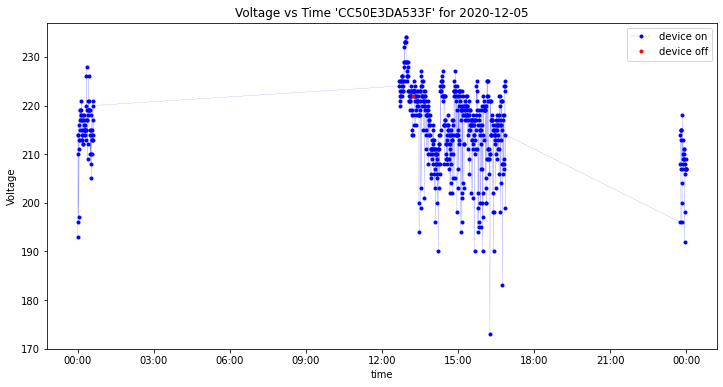

In [26]:
# Plot for Voltage vs Time CC50E3DA533F
fig, ax = plt.subplots(1,1,figsize=(12,6))
on = df_mac1[df_mac1['devicestatus']=='on']
off = df_mac1[df_mac1['devicestatus']=='off']
ax.plot(on["timestamp"], on["voltage"], 'b.-', lw=0.1, label='device on')
ax.plot(off["timestamp"], off["voltage"], 'r.-', lw=0.1,label='device off')

ax.set_title(f'Voltage vs Time \'CC50E3DA533F\' for {start_date}')
ax.set_xlabel('time')
ax.set_ylabel('Voltage')
ax.legend()


myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
ax.xaxis.set_major_formatter(myFmt)
plt.show()

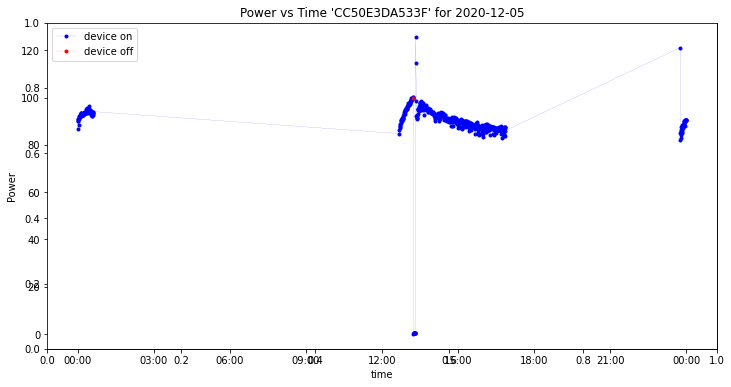

In [30]:
# Plot for Power vs Time CC50E3DA533F
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = fig.add_subplot(111)
on = df_mac1[df_mac1['devicestatus']=='on']
off = df_mac1[df_mac1['devicestatus']=='off']
ax.plot(on["timestamp"], on["power"], 'b.-', lw=0.1, label='device on')
ax.plot(off["timestamp"], off["power"], 'r.-', lw=0.1,label='device off')
ax.set_title(f'Power vs Time \'CC50E3DA533F\' for {start_date}')
ax.set_xlabel('time')
ax.set_ylabel('Power')
plt.legend()
myFmt = mdates.DateFormatter('%H:%M') # format timestamp to Hour:Minute
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

In [36]:
## groupby mac addresses
df_grouped_mac = df.copy()
df_grouped_mac['date']= df_grouped_mac.timestamp.dt.date
df_grouped_mac['date']= pd.to_datetime(df_grouped_mac['date'])
df_grouped_mac['duration'] = df_grouped_mac.groupby(['mac', 'date'])['timestamp'].diff().dt.total_seconds().fillna(0)
# if it takes more than a minute to record data, the duration is marked as no data received
df_grouped_mac.loc[df_grouped_mac['duration'] >=60, 'devicestatus'] = 'no_data_received' # setting a timeout threshold

## Apply filters
mac_address = ['CC50E3DA533F','CC50E304FA9A'] # select these mac addresses
date = ['2020-09-23'] # select these dates
tmp = df_grouped_mac.groupby(['mac','date','devicestatus'])['duration'].sum().reset_index()
tmp['duration_in_hours'] = tmp['duration'].apply(convert2hours)
tmp[tmp['mac'].isin(mac_address) & tmp['date'].isin(date)]

,mac,date,devicestatus,duration,duration_in_hours
124,CC50E304FA9A,2020-09-23,no_data_received,3604.0,1:00:04
125,CC50E304FA9A,2020-09-23,on,40572.0,11:16:12
217,CC50E3DA533F,2020-09-23,no_data_received,5684.0,1:34:44
218,CC50E3DA533F,2020-09-23,off,238.0,0:03:58
219,CC50E3DA533F,2020-09-23,on,80441.0,22:20:41


## Voltage and Time

In [11]:
df1 = df[df.device_deployed=='Yes']

In [12]:
df1.mac.unique()

array(['CC50E304FA9A', 'CC50E304FADC', 'CC50E3DA533F', '84CCA89A1706',
       '84CCA899CEE2', '84CCA899D15B', '84CCA89A48AF', '84CCA89B799C',
       '84CCA899FCA7', '84CCA899F97E'], dtype=object)

In [13]:
%%time
## groupby mac addresses
df_grouped_mac = df1.copy()
df_grouped_mac['date']= df_grouped_mac.timestamp.dt.date
df_grouped_mac['date']= pd.to_datetime(df_grouped_mac['date'])
x = df_grouped_mac.groupby(['mac', 'date'])
df2 = pd.DataFrame([])
for name,group in x:
    grp_year = group.date.iloc[0].year
    grp_month = group.date.iloc[0].month
    grp_day = group.date.iloc[0].day
    first_row = pd.DataFrame({'id':np.nan, 'status':np.nan, 'userid':np.nan, 
                            'timestamp':pd.Timestamp(grp_year, grp_month, grp_day, 0), 
                            'mac':group.mac.iloc[0], 'current':np.nan, 
                            'voltage':np.nan, 'power':np.nan, 'devicestatus':np.nan,
                            'device_deployed':np.nan, 'date':group.date.iloc[0]
                           }, index =[0]) 
    last_row = pd.DataFrame({'id':np.nan, 'status':np.nan, 'userid':np.nan, 
                        'timestamp':pd.Timestamp(grp_year, grp_month, grp_day, 23,59,59), 
                        'mac':group.mac.iloc[0], 'current':np.nan, 
                        'voltage':np.nan, 'power':np.nan, 'devicestatus':np.nan,
                        'device_deployed':np.nan, 'date':group.date.iloc[0]
                       }, index =[0]) 
    group = pd.concat([first_row, group, last_row]).reset_index(drop = True)
    df2 = pd.concat([df2,group]).reset_index(drop = True)
df2['duration'] = df2.groupby(['mac', 'date'])['timestamp'].diff().dt.total_seconds().fillna(0)
# if it takes more than a minute to record data, the duration is marked as no data received
df2.loc[df2['duration'] >=60, 'devicestatus'] = 'no_data_received' # setting a timeout threshold
df2['duration_in_hours'] = df2['duration'].apply(convert2hours)
df2['duration'] = df2['duration'].div(3600)


CPU times: user 42.8 s, sys: 8.28 s, total: 51.1 s
Wall time: 54.4 s


In [39]:
list(df2.mac.unique())

['84CCA899CEE2',
 '84CCA899D15B',
 '84CCA899F97E',
 '84CCA899FCA7',
 '84CCA89A1706',
 '84CCA89A48AF',
 '84CCA89B799C',
 'CC50E304FA9A',
 'CC50E304FADC',
 'CC50E3DA533F']

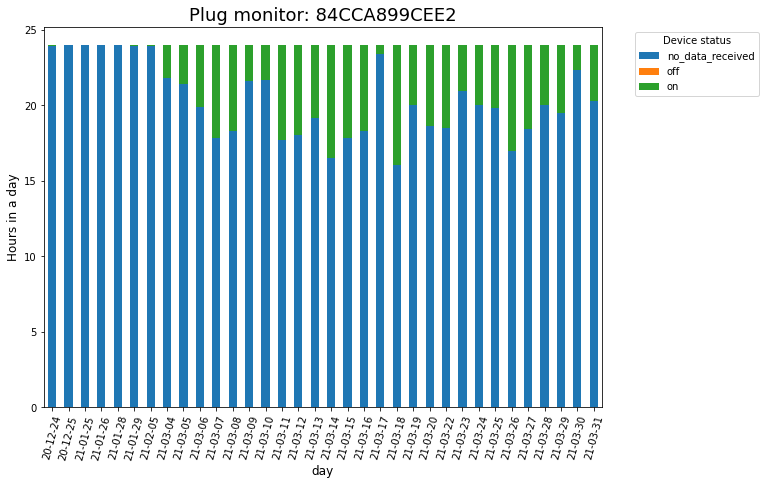

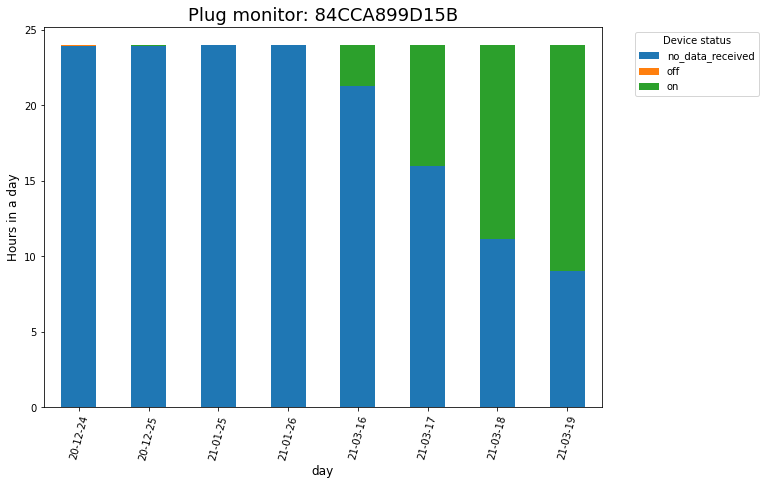

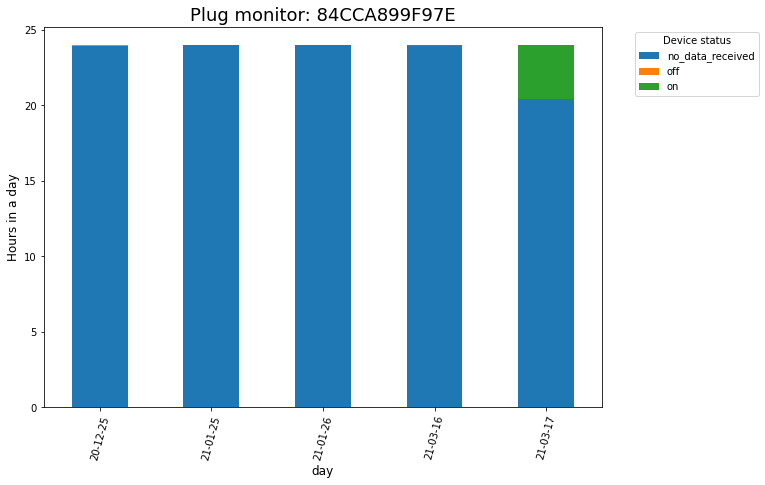

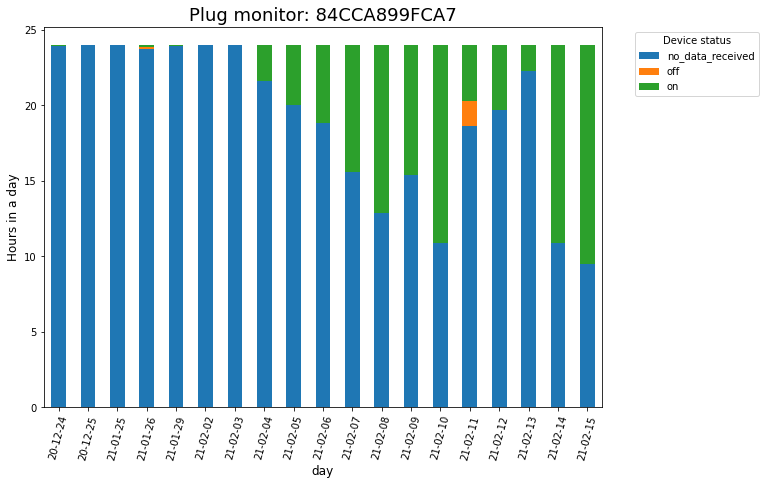

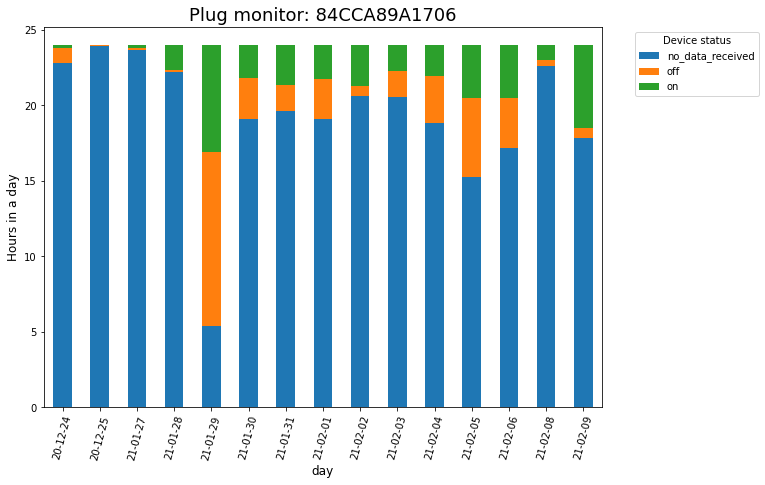

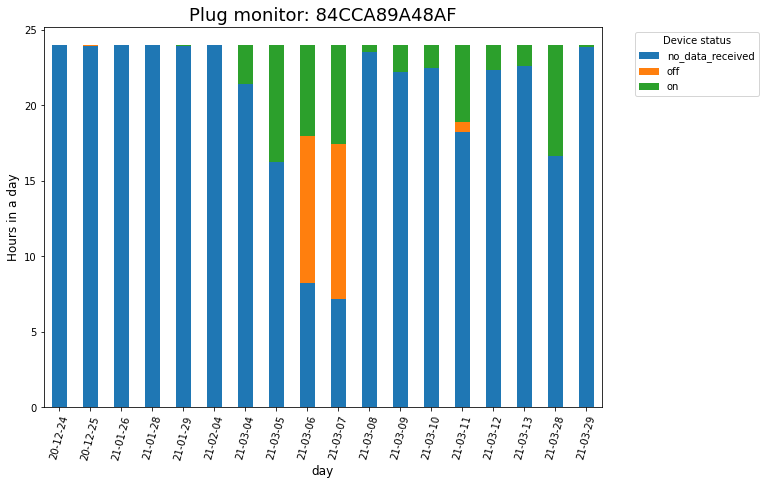

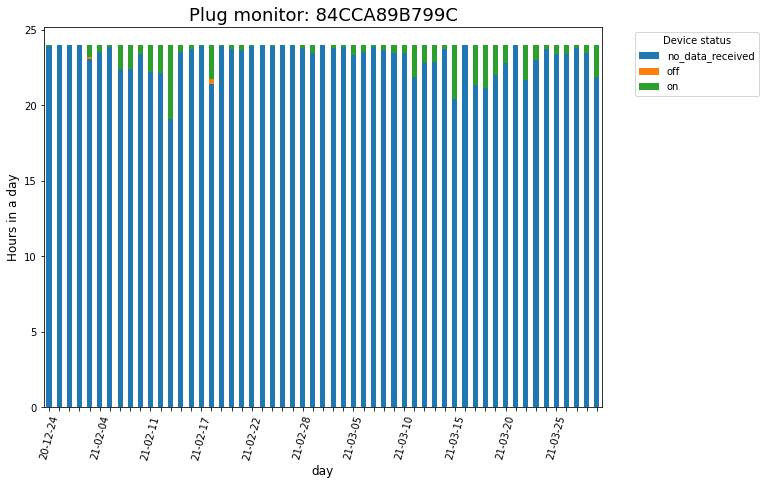

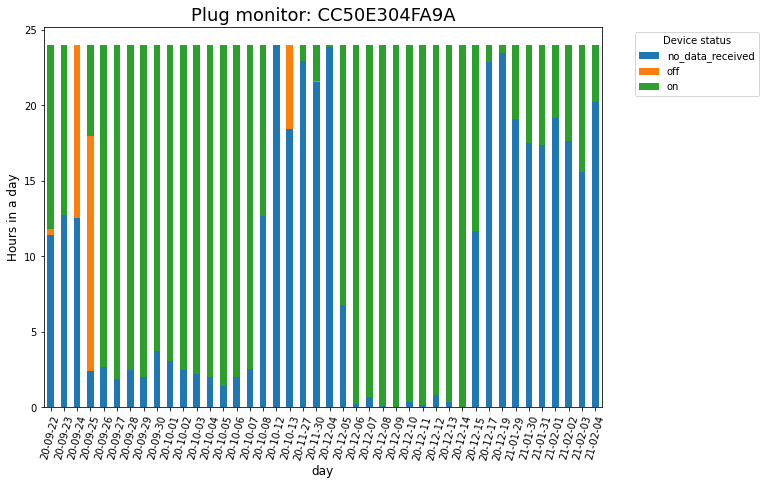

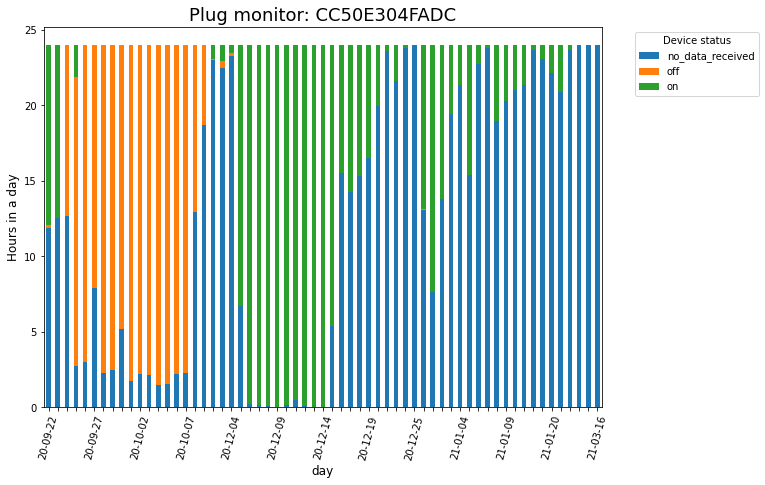

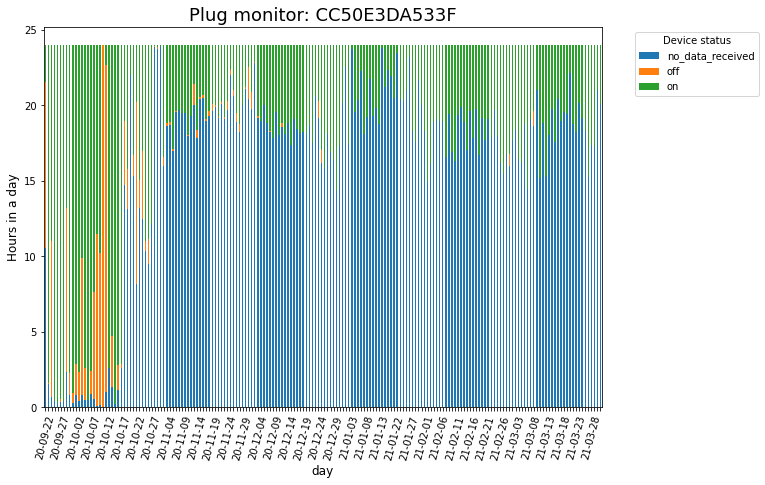

In [11]:
for i in list(df2.mac.unique()):
    p = df2[df2.mac==i]
    q = p.groupby(['mac','date','devicestatus'])['duration'].sum().unstack('devicestatus').fillna(0)
    ax = q.plot(kind='bar', stacked=True, figsize=(10,7))
    ax.set_xlabel('day', fontsize=12)
    ax.set_ylabel('Hours in a day', fontsize=12)
    ax.set_title(f'Plug monitor: {i}', fontsize=18)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([item[17:25] for item in labels])
    if len(labels) > 50:
        every_nth = 5
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
    plt.xticks(rotation=75)
    plt.legend( title='Device status', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [14]:
df3 = df2.groupby(['mac','date'])['voltage'].mean().reset_index()

In [43]:
df3 = df3[df3.date > '2021-03-16']

In [47]:
df3

,mac,date,voltage
20,84CCA899CEE2,2021-03-17,225.944444
21,84CCA899CEE2,2021-03-18,234.147028
22,84CCA899CEE2,2021-03-19,239.527083
23,84CCA899CEE2,2021-03-20,232.614551
24,84CCA899CEE2,2021-03-22,236.885023
...,...,...,...
479,CC50E3DA533F,2021-04-12,195.062753
480,CC50E3DA533F,2021-04-13,208.264297
481,CC50E3DA533F,2021-04-14,203.408696
482,CC50E3DA533F,2021-04-15,205.452244


In [47]:
single_mac = df[df.mac=='84CCA899D15B']
single_mac = single_mac[single_mac.timestamp > '2021-03-10']
single_mac

,id,status,userid,timestamp,mac,current,voltage,power,devicestatus,device_deployed
444122,444123,1,505,2021-03-16 18:08:21,84CCA899D15B,0.00,266,0.05,on,Yes
444123,444124,1,505,2021-03-16 18:08:45,84CCA899D15B,0.01,264,0.03,on,Yes
444124,444125,1,505,2021-03-16 18:09:14,84CCA899D15B,0.00,264,0.01,on,Yes
444125,444126,1,505,2021-03-16 18:09:46,84CCA899D15B,0.01,263,0.59,on,Yes
444126,444127,1,505,2021-03-16 18:10:14,84CCA899D15B,0.01,266,0.67,on,Yes
...,...,...,...,...,...,...,...,...,...,...
453421,453422,1,505,2021-03-19 17:35:21,84CCA899D15B,0.74,286,117.63,on,Yes
453422,453423,1,505,2021-03-19 17:35:52,84CCA899D15B,0.68,267,111.82,on,Yes
453423,453424,1,505,2021-03-19 17:36:21,84CCA899D15B,0.68,269,111.55,on,Yes
453424,453425,1,505,2021-03-19 17:36:52,84CCA899D15B,0.67,266,110.26,on,Yes


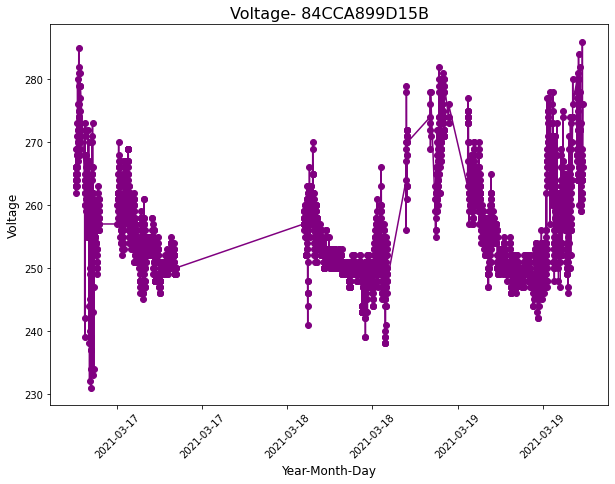

In [49]:
mac_ids = list(df1.mac.unique())
colors = ['red', 'green', 'violet', 'blue', 'purple', 'brown', 'black', 'violet','pink']
fig,ax = plt.subplots(figsize=(10,7))
# for n,i in enumerate(mac_ids):
#     ax.plot(df3[df3.mac==i].date, df3[df3.mac==i].voltage, color=colors[n], marker='o',label=i)

ax.plot(single_mac[single_mac.mac=='84CCA899D15B'].timestamp, 
        single_mac[single_mac.mac=='84CCA899D15B'].voltage, color="purple",marker='o',)
ax.set_xlabel('Year-Month-Day', fontsize=12)
ax.set_ylabel('Voltage', fontsize=12)
ax.set_title(f'Voltage- 84CCA899D15B', fontsize=16)
plt.xticks(rotation=45)
myFmt = mdates.DateFormatter('%Y-%m-%d') # format timestamp to Hour:Minute
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

In [12]:
hrs_df = pd.DataFrame([])
for i in list(df2.mac.unique()):
    p = df2[df2.mac==i]
    q = p.groupby(['mac','date','devicestatus'])['duration'].sum().unstack('devicestatus').fillna(0)
    hrs_df = pd.concat([hrs_df, q])
    

In [13]:
hrs_df.to_csv("/Users/joelmugyenyi/Desktop/U20/hrs.csv")

In [23]:
mac_ids

['CC50E304FA9A',
 'CC50E3DA533F',
 '84CCA89A1706',
 '84CCA899CEE2',
 '84CCA899D15B',
 '84CCA89A48AF',
 '84CCA89B799C',
 '84CCA899FCA7',
 '84CCA899F97E']

In [50]:
df3.to_csv("/Users/joelmugyenyi/Desktop/U20/average_volt.csv")

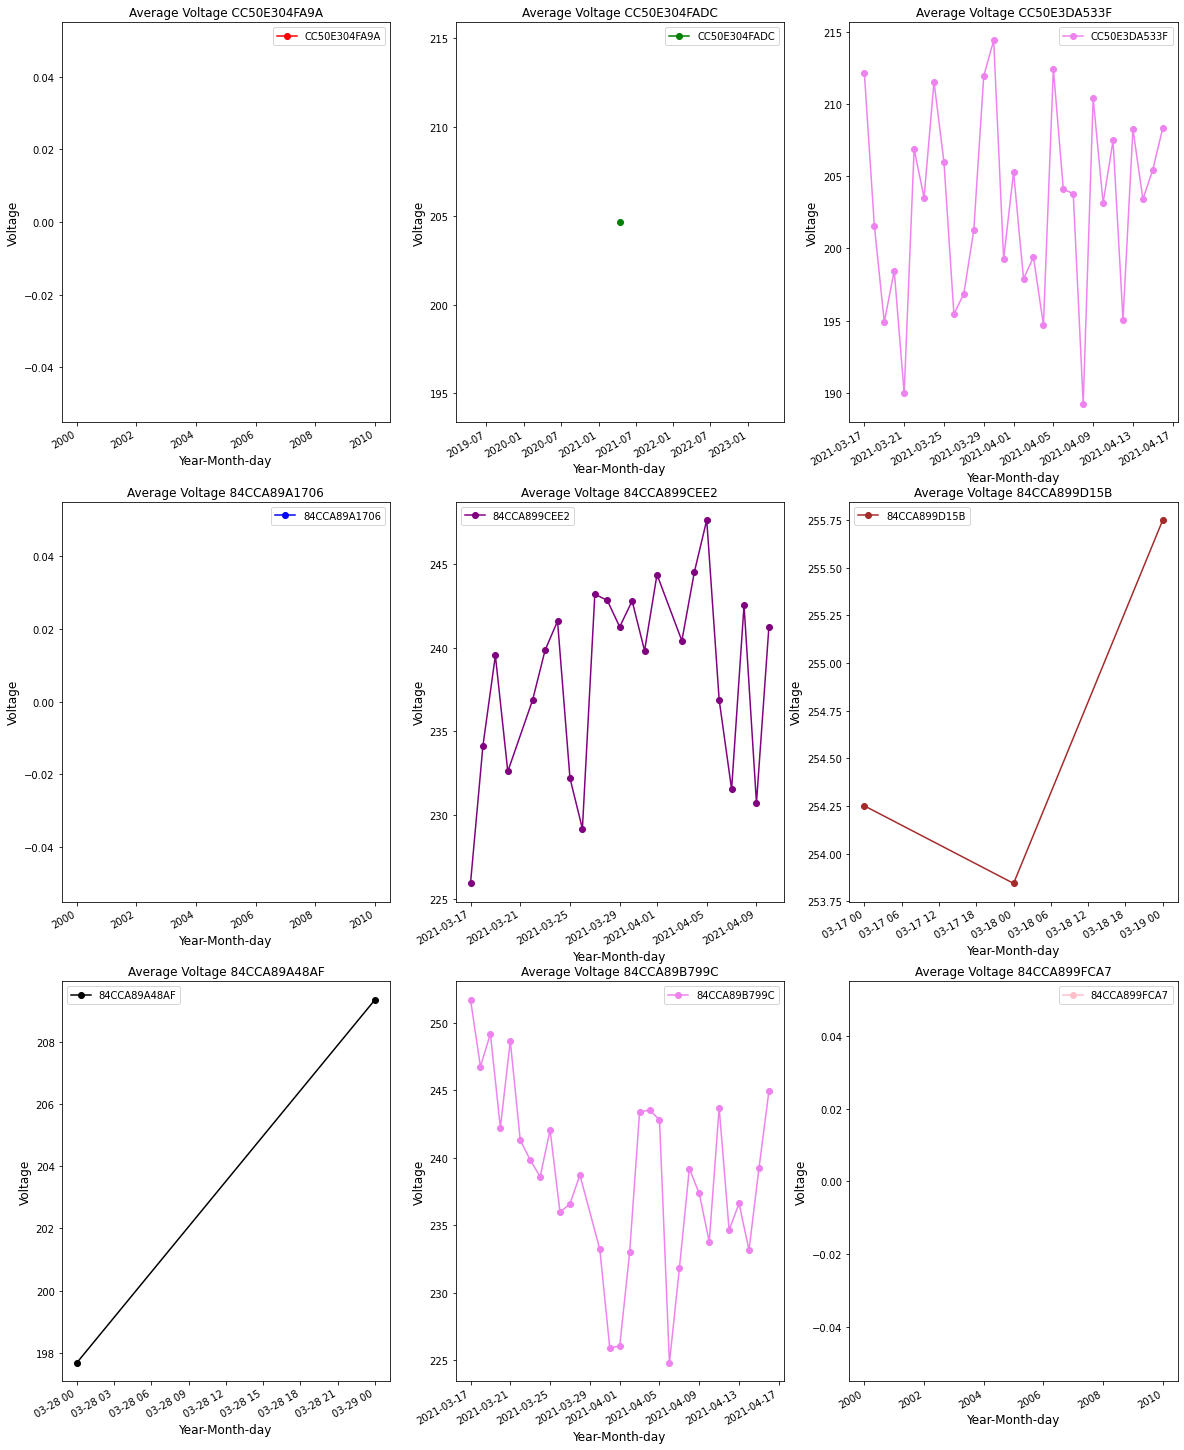

In [46]:
mac_ids = list(df1.mac.unique())
colors = ['red', 'green', 'violet', 'blue', 'purple', 'brown', 'black', 'violet','pink']
fig,ax = plt.subplots(3, 3, figsize=(20,25))
i = 0
for j in range(0,3):
    for n in range(0,3):
        ax[j,n].plot(df3[df3.mac==mac_ids[i]].date, df3[df3.mac==mac_ids[i]].voltage,
                     color=colors[i], marker='o',label=mac_ids[i])
        
        ax[j,n].set_title(f'Average Voltage {mac_ids[i]}', fontsize=12)
        ax[j,n].legend()
        ax[j,n].set_xlabel('Year-Month-day', fontsize=12)
        ax[j,n].set_ylabel('Voltage', fontsize=12)
        for label in ax[j,n].get_xticklabels():
            label.set_rotation(30)
            label.set_ha('right')
#         ax[j,n].set_xticklabels(ax[j,n].get_xticklabels(), rotation=90, ha='right')
        i = i+1
plt.show()

In [49]:
!pwd

/Users/joelmugyenyi/Desktop/U20/data_management
